In [13]:
import gym
from gym import spaces

import pygame
import cv2

import numpy as np
import math
import random

import matplotlib.pyplot as plt

import os

os.environ["SDL_VIDEODRIVER"] = "dummy"

class FooEnv(gym.Env):

    def __init__(self, render_mode = "rgb_array"):
        super(FooEnv, self).__init__()
        metadata = {'render.modes': ['rgb_array']}
        '''
        maze = [['#', '#', '#', '#', '.', '.', '#', '#'],
                ['#', '.', '.', '.', '.', '.', '.', '#'],
                ['#', '.', '#', '#', '#', '#', '.', '#'],
                ['#', '.', '.', '#', '#', '#', '.', '.'],
                ['#', '#', '.', '.', '.', '#', '#', '.'],
                ['.', '.', '.', '#', '.', '.', '.', '.'],
                ['.', '#', '.', '#', '.', '#', '.', 'G'],
                ['.', 'S', '.', '.', '.', '#', '#', '#']]
        '''

        self.was_called = 0

        self.matrix_size = 16
        self.maze = self.make_maze(self.matrix_size)
        #self.maze = np.array(maze)

        self.episode_length = 0
        self.episode_total_length = 128

        self.box_low = -1
        self.box_high = 17
        self.obs_space_shape = (2, 4)

        #self.start_pos = np.where(self.maze == 'S')  # Starting position
        self.start_pos = np.array([np.where(self.maze == 'S')[0][0], np.where(self.maze == 'S')[1][0]])

        #self.goal_pos = np.where(self.maze == 'G')  # Goal position
        self.goal_pos = np.array([np.where(self.maze == 'G')[0][0], np.where(self.maze == 'G')[1][0]])

        self.current_pos = self.start_pos #starting position is current posiiton of agent
        self.num_rows, self.num_cols = self.maze.shape

        self.last_pos_hashtag_was_called = self.start_pos

        # 4 possible actions: 0=up, 1=down, 2=left, 3=right
        self.action_space = spaces.Discrete(4)

        # Observation space is grid of size:rows x columns
        #self.observation_space = spaces.Tuple((spaces.Discrete(self.num_rows), spaces.Discrete(self.num_cols)))
        self.observation_space = spaces.Box(low=self.box_low, high=self.box_high, shape=self.obs_space_shape, dtype=np.float32)

        self.ret_state = np.zeros(self.obs_space_shape, dtype=np.float32)
        self.ret_state[0, 2], self.ret_state[0, 3] = self.goal_pos
        self.ret_state[0, 0], self.ret_state[0, 1] = self.current_pos

        self.ret_state[1, 0:4] = self.blocked_neighbors()

        # Initialize Pygame
        pygame.init()
        self.cell_size = 128
        #self.render_mode == "rgb_array_list"

        # setting display size
        self.screen = pygame.display.set_mode((self.num_cols * self.cell_size, self.num_rows * self.cell_size))

    def blocked_neighbors(self):
        x, y = self.current_pos
        neighbor_positions = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]

        blocked_neighbors = [0]*4

        for index, position in enumerate(neighbor_positions):
            if self.is_valid_move(self.matrix_size, position):
                if self.maze[position[0], position[1]] == '#':
                    blocked_neighbors[index] = 10

        return blocked_neighbors




    def is_valid_move(self, maze_size, pos):
        x, y = pos
        return 0 <= x < maze_size and 0 <= y < maze_size

    def make_maze(self, maze_size):
      maze = np.full((maze_size, maze_size), "#")  # Start with all obstacles

      position = (random.randint(0, maze_size-1), random.randint(0, maze_size-1))

      # Number of steps to take, approximately half of the maze elements
      steps = maze_size * maze_size

      for step in range(steps):

          # Make a move
          while True:

              action = random.randint(0, 1) if random.randint(0, 1) == 0 else random.randint(2, 3)
              if action == 0:
                  new_pos = (position[0] - 1, position[1])
              elif action == 2:
                  new_pos = (position[0], position[1] + 1)
              elif action == 1:
                  new_pos = (position[0] + 1, position[1])
              elif action == 3:
                  new_pos = (position[0], position[1] - 1)

              # Check if the move is valid
              if self.is_valid_move(maze_size, new_pos):
                  break

          # Change the symbol if the new position is valid
          position = new_pos
          maze[new_pos] = "."

          if step == 0:
            start_pos = new_pos
          elif step == steps - 1:
            stop_pos = new_pos

      maze[start_pos] = "S"
      maze[stop_pos] = "G"

      return maze

    def reset(self):

        self.was_called = 0

        self.episode_length = 0

        self.maze = self.make_maze(self.matrix_size)

        self.start_pos = np.array([np.where(self.maze == 'S')[0][0], np.where(self.maze == 'S')[1][0]])

        self.goal_pos = np.array([np.where(self.maze == 'G')[0][0], np.where(self.maze == 'G')[1][0]])

        self.current_pos = self.start_pos #starting position is current posiiton of agent
        self.last_pos_hashtag_was_called = self.start_pos

        self.ret_state = np.zeros(self.obs_space_shape, dtype=np.float32)

        self.ret_state[0, 2], self.ret_state[0, 3] = self.goal_pos
        self.ret_state[0, 0], self.ret_state[0, 1] = self.current_pos

        self.ret_state[1, 0:4] = self.blocked_neighbors()

        return self.ret_state

    def step(self, action):
        self.episode_length = self.episode_length + 1
        # Move the agent based on the selected action
        new_pos = np.array(self.current_pos)
        if action == 0:  # Up
            new_pos[0] -= 1
        elif action == 1:  # Down
            new_pos[0] += 1
        elif action == 2:  # Left
            new_pos[1] -= 1
        elif action == 3:  # Right
            new_pos[1] += 1

        # Check if the new position is valid
        if self._is_valid_position(new_pos):
            self.current_pos = np.array([new_pos[0], new_pos[1]])

            self.ret_state[0, 0], self.ret_state[0, 1] = self.current_pos
            self.ret_state[1, 0:4] = self.blocked_neighbors()


        # Reward function
        if np.array_equal(self.current_pos, self.goal_pos):
            reward = 1.0
            done = True
        else:
            reward = 0.0
            done = False

        if self.episode_length == self.episode_total_length and not done:
            done = True
            reward = 0.0

        row, col = new_pos
        if row >= 0 and col >= 0 and row < self.num_rows and col < self.num_cols:
            if self.maze[row, col] == '#':
                if np.array_equal(self.last_pos_hashtag_was_called, new_pos):
                    self.was_called += 1
                else:
                    self.last_pos_hashtag_was_called = new_pos
                    self.was_called = 0

                if self.was_called == 2:
                    done = True
                    reward = -1.0


        return self.ret_state, reward, done, {}


    def _is_valid_position(self, pos):
        row, col = pos

        # If agent goes out of the grid
        if row < 0 or col < 0 or row >= self.num_rows or col >= self.num_cols:
            return False

        # If the agent hits an obstacle
        if self.maze[row, col] == '#':
            return False
        return True

    def render(self, mode = "rgb_array"):
        # Clear the screen
        self.screen.fill((255, 255, 255))

        # Draw env elements one cell at a time
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                if self.maze[row, col] == '#':  # Obstacle
                    pygame.draw.rect(self.screen, (0, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':  # Starting position
                    pygame.draw.rect(self.screen, (0, 255, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':  # Goal position
                    pygame.draw.rect(self.screen, (255, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))

                if np.array_equal(self.current_pos, np.array([row, col])): #.reshape(-1,1)):  # Agent position
                    pygame.draw.rect(self.screen, (0, 0, 255), (cell_left, cell_top, self.cell_size, self.cell_size))

        pygame.display.update()  # Update the display

        #convert image so it can be displayed in OpenCV
        view = pygame.surfarray.array3d(self.screen)

        #  convert from (width, height, channel) to (height, width, channel)
        view = view.transpose([1, 0, 2])

        #  convert from rgb to bgr
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        return img_bgr


In [17]:
GymEnv = FooEnv()


In [18]:
GymEnv.step(1)

(array([[15.,  6.,  2.,  0.],
        [ 0.,  0., 10.,  0.]], dtype=float32),
 0.0,
 False,
 {})

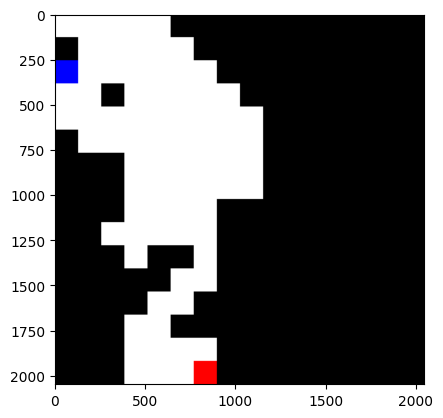

In [19]:
plt.imshow(GymEnv.render())
plt.show()